In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.datasets.cifar10 import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
import matplotlib.pyplot as plt
import tensorflow as tf

In [17]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [18]:
# load CIFAR10 dataset
(X_train, y_labels), (_, _) = load_data()

# load and prepare cifar10 training images
def load_real_normalized_samples(features):
	# convert from unsigned ints to floats
	X = features.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X

# load image data
dataset = load_real_normalized_samples(X_train)

In [19]:
dataset.shape

(50000, 32, 32, 3)

<h3> The classes within the dataset are:</h3>
- airplane</br>
- automobile</br>
- bird</br>
- cat</br>
- deer</br>
- dog</br>
- frog</br>
- horse</br>
- ship</br>
- truck</br>

In [20]:
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [21]:
# Get the counts of samples in X_train
num_samples = len(X_train)

# Get the counts of each class in y_train
class_counts = {class_index: count for class_index, count in zip(*np.unique(y_labels, return_counts=True))}

# Display the counts
print("Number of samples in X_train:", num_samples)
print("Class counts:")
for class_index, count in class_counts.items():
    print(f"{classes[class_index]}: {count} samples")

Number of samples in X_train: 50000
Class counts:
airplane: 5000 samples
automobile: 5000 samples
bird: 5000 samples
cat: 5000 samples
deer: 5000 samples
dog: 5000 samples
frog: 5000 samples
horse: 5000 samples
ship: 5000 samples
truck: 5000 samples


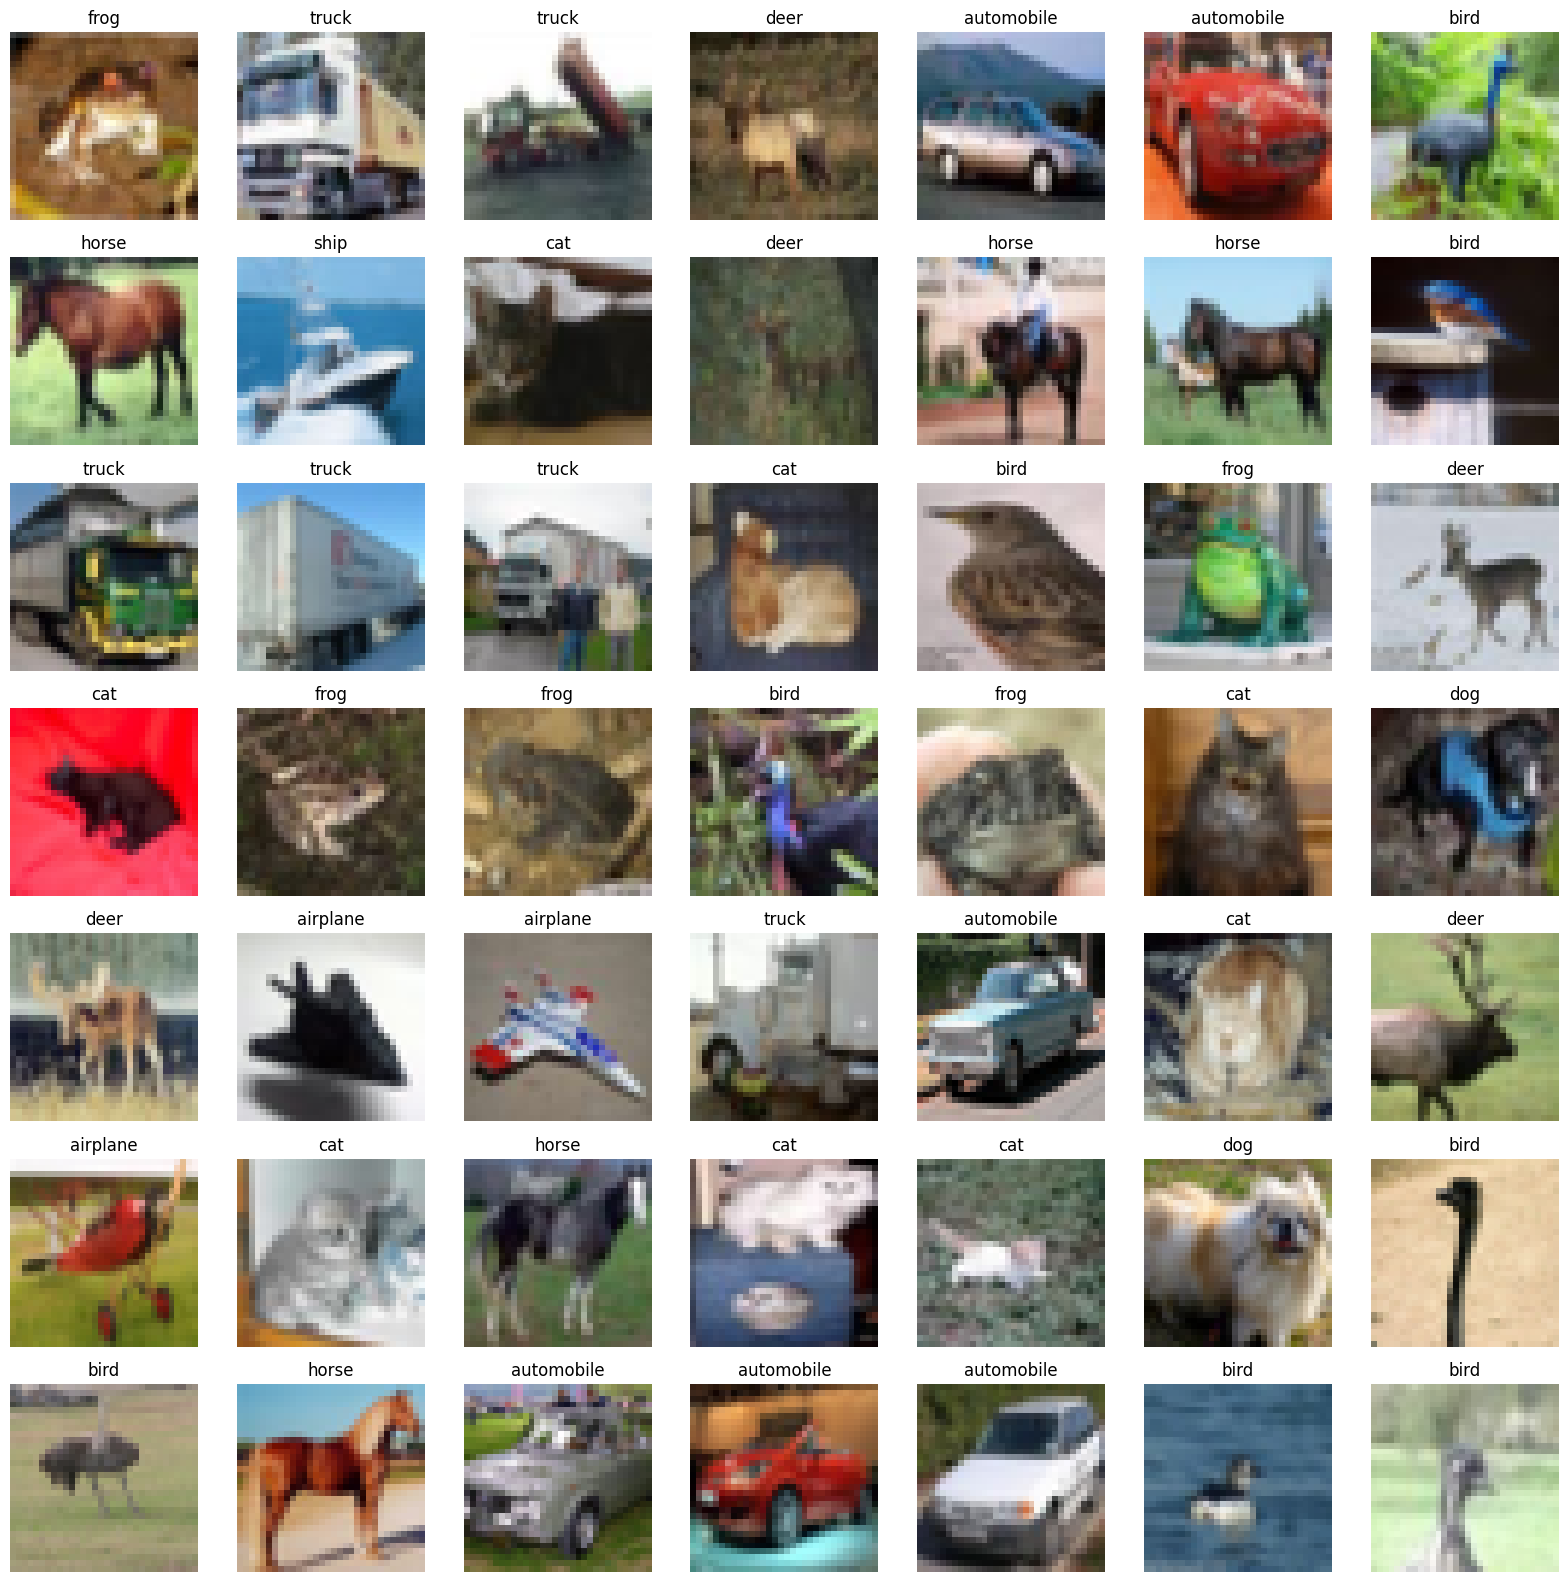

In [22]:
# plot images from the training dataset
fig = plt.figure(0)
fig.set_size_inches(20, 20)
for i in range(49):
    # define subplot
    plt.subplot(7, 7, 1 + i)
    # turn off axis
    plt.axis('off')
    # plot raw pixel data
    plt.imshow(X_train[i])
    plt.title(f'{(classes[int(y_labels[i])])}')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

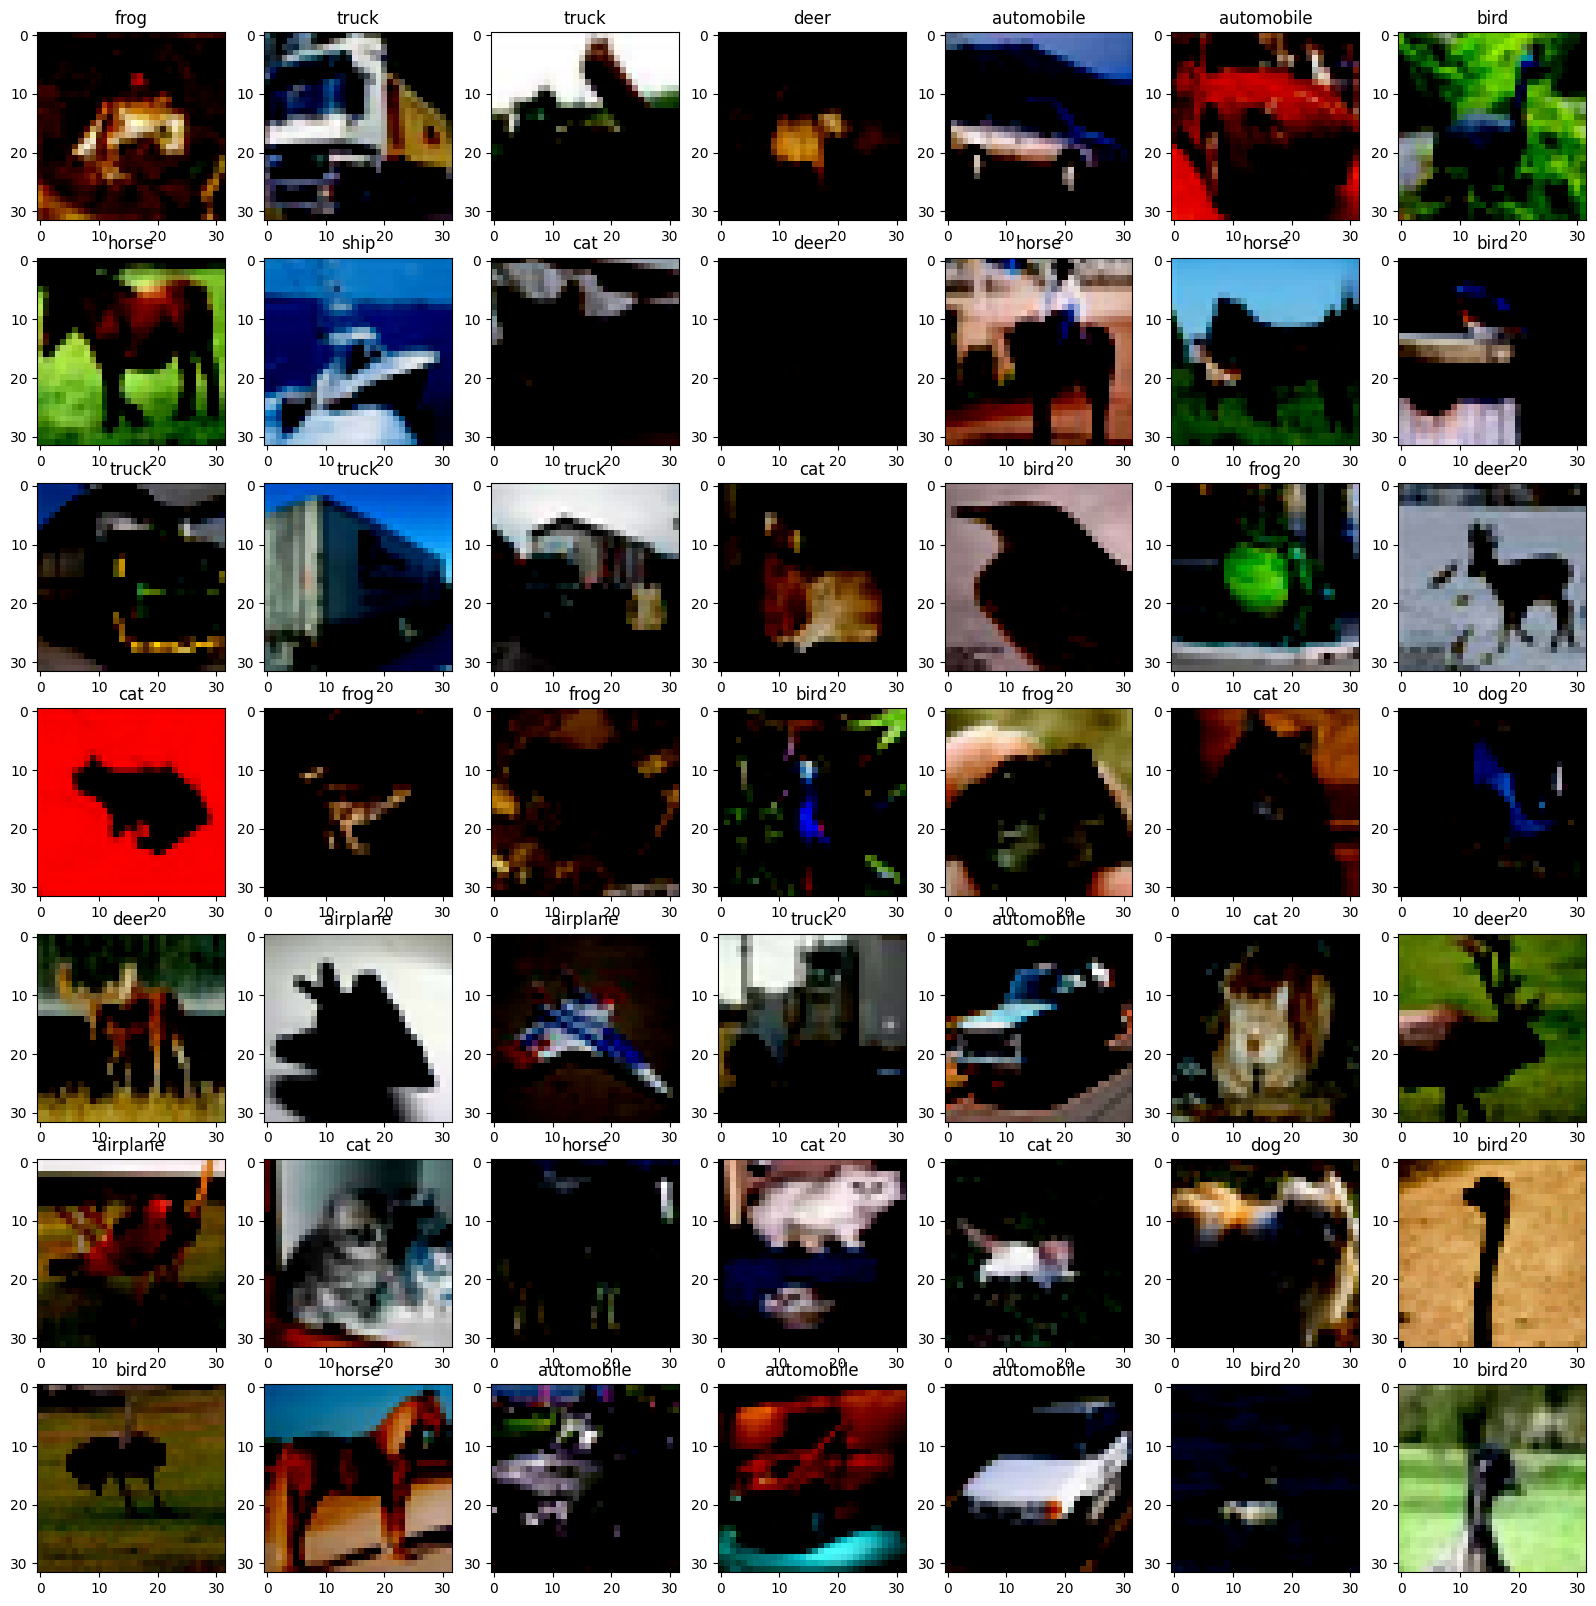

In [23]:
# Show normalized images
fig = plt.figure(0)
fig.set_size_inches(20, 20)
for i in range(0,49):
    fig.add_subplot(7, 7, i+1)
    plt.imshow(dataset[i])
    plt.title((classes[int(y_labels[i])]))

<h4> Data Augmentation</h4>

In [24]:
def data_augmentation(undersampled_data):
    AugImageArr = []
    for images in undersampled_data:
        image = tf.image.random_flip_left_right(images)
        image = tf.image.random_crop(
            image, size=(32,32,3)
        )
        AugImageArr.append(tf.reshape(image, (32,32,3)))
    return np.array(AugImageArr)

<h4>Data Preparation</h4>

<h4>Build Models</h4>

In [30]:
from keras.models import Sequential
from keras.layers import Dense, Reshape, BatchNormalization, UpSampling2D
from keras.optimizers import RMSprop
from keras import backend as K

# Define Wasserstein loss
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

In [25]:
def build_generator():
    model = Sequential()

    # Project and reshape the random noise
    model.add(Dense(4 * 4 * 512, input_dim=100))
    model.add(Reshape((4, 4, 512)))
    model.add(BatchNormalization(momentum=0.8))
    
    # Upsample to 8x8
    model.add(UpSampling2D())
    model.add(Conv2D(256, kernel_size=3, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    
    # Upsample to 16x16
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=3, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    
    # Upsample to 32x32
    model.add(UpSampling2D())
    model.add(Conv2D(64, kernel_size=3, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    
    # Output layer with tanh activation
    model.add(Conv2D(3, kernel_size=3, padding='same', activation='tanh'))

    return model

# Create a WGAN generator
generator = build_generator()

# Compile the model with RMSprop optimizer and custom Wasserstein loss
optimizer = RMSprop(lr=0.00005)
generator.compile(loss=wasserstein_loss, optimizer=optimizer)

# Display the summary of the generator model
generator.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 8192)              827392    
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 512)         0         
                                                                 
 batch_normalization_4 (Batc  (None, 4, 4, 512)        2048      
 hNormalization)                                                 
                                                                 
 up_sampling2d_3 (UpSampling  (None, 8, 8, 512)        0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 256)         1179904   
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 8, 8, 256)        

In [26]:
# Build the discriminator
def build_discriminator():
    model = Sequential()

    # Input layer with shape (32, 32, 3)
    model.add(Conv2D(64, kernel_size=3, strides=(2,2), padding='same', input_shape=(32, 32, 3)))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(128, kernel_size=3, strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(256, kernel_size=3, strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Flatten())
    model.add(Dropout(0.3))
    model.add(Dense(1))

    return model

# Create a WGAN discriminator
discriminator = build_discriminator()

# Compile the model with RMSprop optimizer and custom Wasserstein loss
optimizer = RMSprop(lr=0.00003)
discriminator.compile(loss=wasserstein_loss, optimizer=optimizer, metrics=['accuracy'])

# Display the summary of the discriminator model
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 16, 16, 64)        1792      
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 8, 8, 128)         73856     
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 conv2d_13 (Conv2D)          (None, 4, 4, 256)         295168    
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 4, 4, 256)         0         
                                                                 
 flatten_1 (Flatten)         (None, 4096)             

In [29]:


    return model